## OCC solution

In [32]:
import numpy as np
import random
from sklearn.linear_model import LogisticRegression
import sys
sys.path.append('.\\..\\..\\Chapter2-Z24-dataset')
from predict import binarize
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import classification_report, accuracy_score

In [33]:
X_train = np.load("C:\\Users\\amroa\\Documents\\thesis\\X_train.npy")
labels_train = np.load("C:\\Users\\amroa\\Documents\\thesis\\labels_train.npy")
X_test = np.load("C:\\Users\\amroa\\Documents\\thesis\\X_test.npy")
labels_test = np.load("C:\\Users\\amroa\\Documents\\thesis\\labels_test.npy")

In [34]:
# extract the relevant file indices for training and testing separately
test_indices=  np.array([])
train_indices=  np.array([])

for i in range(17):
    random.seed(i)
    nbr_splits = 36 #  recall 612/17 = 36, where 612 = total nbr of epochs, 17 is nbr of scenarios
    test_split = 4
    test_indices_temp = np.array(random.sample(range(nbr_splits), test_split))
    test_indices = np.append(test_indices, i*nbr_splits + test_indices_temp)
    train_indices = np.append(train_indices,  i*nbr_splits+ np.array([x for x in range(nbr_splits) if x not in test_indices_temp]))

print(len(train_indices))

544


In [35]:
train_ctr = 0
test_ctr = 0
data_all = []
labels_all = []
for i in range(612):
    if i in train_indices:
        data_all.append(X_train[train_ctr])
        labels_all.append(labels_train[train_ctr])
        train_ctr += 1
    elif i in test_indices:
        data_all.append(X_test[test_ctr])
        labels_all.append(labels_test[test_ctr])
        test_ctr += 1

In [36]:
y_all = binarize(labels_all) # is the labels of all instances 
data_all = np.array(data_all) # are all the instances

In [37]:
# define hyperparameters and data
features_to_keep = 79
neighbors = 41
log_reg = LogisticRegression(C = 12.5) 
y_train = binarize(labels_train)
log_reg.fit(X_train, y_train)
sorted_feature_indices = np.argsort(log_reg.coef_[0])[::-1] # get the indices of the most important features in descending order
indices = sorted_feature_indices[:features_to_keep]
data_all_top = data_all[:, indices] 

In [38]:
healthy_data = data_all_top[y_all == 0]
unhealthy_data = data_all_top[y_all == 1]
healthy_data.shape, unhealthy_data.shape

((288, 79), (324, 79))

In [39]:
random.seed(42)
test_size = 0.25
healthy_train, healthy_test = train_test_split(healthy_data, test_size=test_size, stratify=np.repeat(np.arange(8), 36), random_state=42)
dam_test = unhealthy_data
healthy_train.shape, dam_test.shape, healthy_test.shape

((216, 79), (324, 79), (72, 79))

In [40]:
train_data = healthy_train
train_labels = np.full(train_data.shape[0], 1).astype(int)

pca = PCA(n_components=0.9)
sc = StandardScaler()

train_data = sc.fit_transform(train_data)
train_data = pca.fit_transform(train_data)

data_all_sc = sc.transform(data_all_top)
data_all_pca = pca.transform(data_all_sc)

data_all_pca.shape

(612, 34)

In [41]:
param_grid_occ_svm = {
    'nu': [0.01, 0.1, 0.2], 
    'gamma': ['scale', 'auto'],
    'tol': [1e-3, 1e-2, 1e-1]
} # rbf by default

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt
def plt_distr(predictions):
    global data_all_pca
    sns.reset_defaults()
    sns.reset_orig()
    plt.figure(figsize=(15, 6))
    nbr_epochs = data_all_pca.shape[0]

    preds = np.array(predictions).reshape(-1, 1).flatten()
    for i in range(0, nbr_epochs+1, 36):
        plt.axvline(x=i, color='red', linestyle='--', linewidth=0.8)

    obs = np.arange(len(preds))
    plt.bar(obs, preds)
    plt.ylim(0, 1.5)

    plt.xlabel('Epoch (16,384 samples or 2.7 min per epoch)')
    plt.ylabel('Entropies')
    plt.title(f'Changepoints detected')
    text_pos = [i+18 for i in range(0, nbr_epochs, 36)]
    for idx, pos in enumerate(text_pos):
        plt.text(pos, 1.3, f'DS {idx+1}', ha='center', color='red')

    plt.show()

In [43]:
cnt = data_all_top.shape[0]
grace = 10
start = 6
predictions = [0]*start
last_an = 0
for i in range(start, cnt):
    model = GridSearchCV(OneClassSVM(), param_grid_occ_svm, scoring = 'accuracy', cv = 5)

    # if we are in the grace period
    if i - last_an < grace:
        y_pred = 1
        predictions.append(max(-y_pred, 0))
        continue
    
    # we should have enough datapoints to fit and predict
    model.fit(data_all_pca[last_an:i], np.zeros(i-last_an))
    y_pred = model.predict([data_all_pca[i]])[0]

    # here we don't restart from the changepoint
    predictions.append(max(-y_pred, 0)) # anomaly maps to 1 then 1 and normals maps to -1 to 0. 

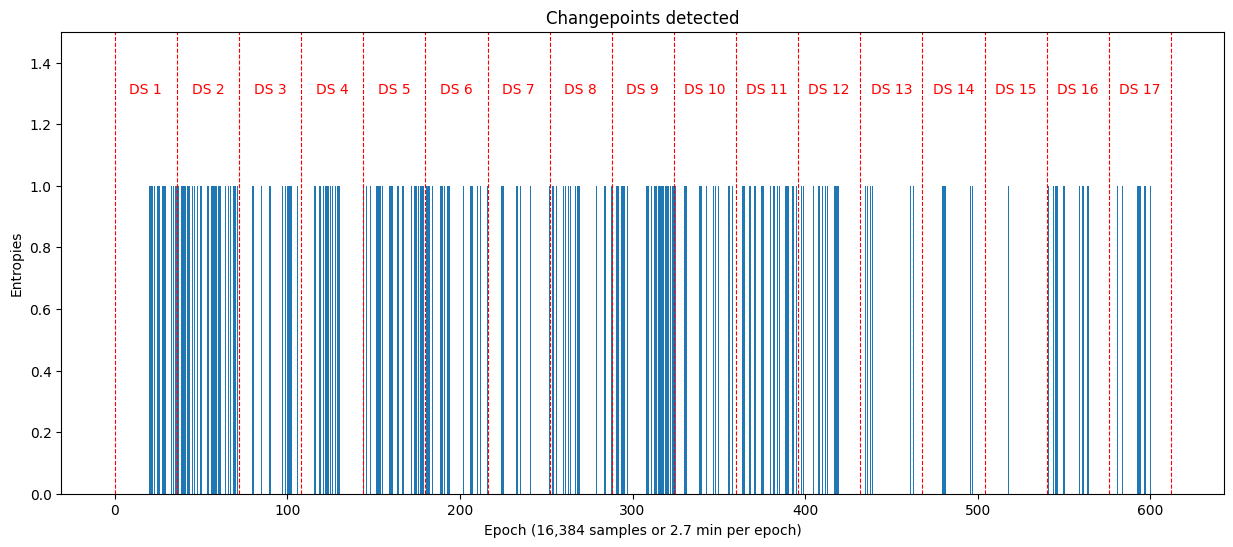

In [53]:
plt_distr(predictions)

In [61]:
cnt = data_all_top.shape[0]
grace = 40
start = 6
predictions = [0]*start
last_an = 0
for i in range(start, cnt):
    model = GridSearchCV(OneClassSVM(), param_grid_occ_svm, scoring = 'accuracy', cv = 5)

    # if we are in the grace period
    if i - last_an < grace:
        y_pred = 1
        predictions.append(max(-y_pred, 0))
        continue
    
    # we should have enough datapoints to fit and predict
    model.fit(data_all_pca[last_an:i], np.zeros(i-last_an))
    y_pred = model.predict([data_all_pca[i]])[0]
    
    # mark current time point as changepoint
    if y_pred == -1:
        last_an = i

    predictions.append(max(-y_pred, 0)) # anomaly maps to 1 then 1 and normals maps to -1 to 0. 

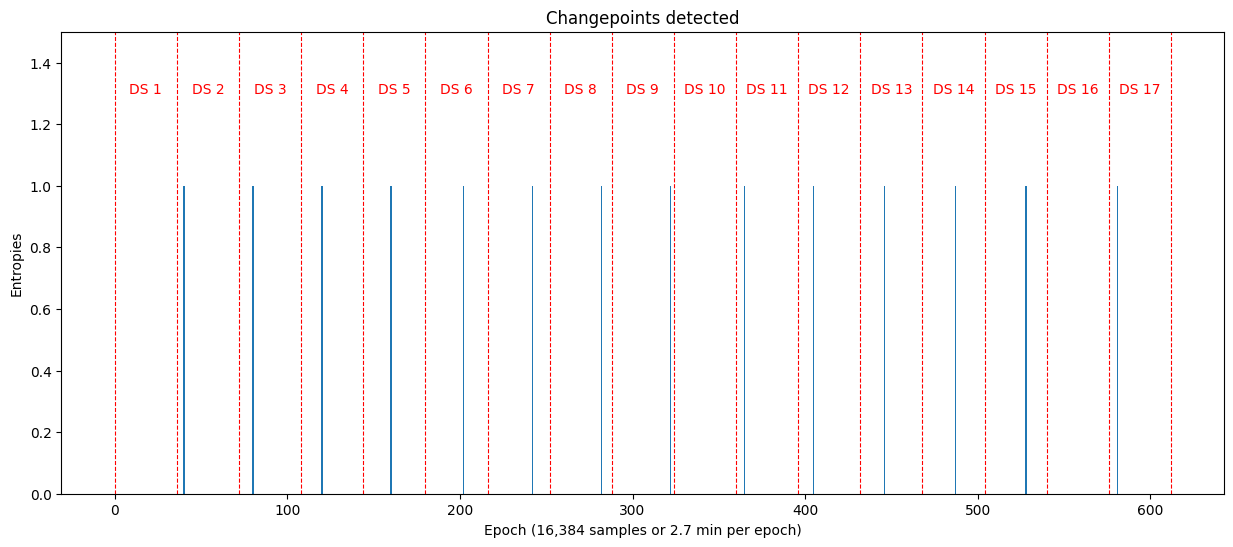

array([ 40,  80, 120, 160, 202, 242, 282, 322, 365, 405, 446, 487, 528,
       581], dtype=int64)

In [62]:
plt_distr(predictions)
np.where(np.array(predictions).astype(int) == 1)[0]

In [10]:
"""
def tune_parameters(healthy_train, combined_validation, len_val_healthy, len_test_healthy, param_grid):
    best_score = 0
    best_params = None
    
    for nu in param_grid['nu']:
        for gamma in param_grid['gamma']:
            model = OneClassSVM(nu=nu, gamma=gamma)
            score, _ = evaluate_model(model, healthy_train, combined_validation, None, len_val_healthy, len_test_healthy, tune=True)
            
            if score > best_score:
                best_score = score
                best_params = {'nu': nu, 'gamma': gamma}
    
    return best_params
"""

"\ndef tune_parameters(healthy_train, combined_validation, len_val_healthy, len_test_healthy, param_grid):\n    best_score = 0\n    best_params = None\n    \n    for nu in param_grid['nu']:\n        for gamma in param_grid['gamma']:\n            model = OneClassSVM(nu=nu, gamma=gamma)\n            score, _ = evaluate_model(model, healthy_train, combined_validation, None, len_val_healthy, len_test_healthy, tune=True)\n            \n            if score > best_score:\n                best_score = score\n                best_params = {'nu': nu, 'gamma': gamma}\n    \n    return best_params\n"

In [63]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as make_imblearn_pipeline

def split_data(healthy_data, unhealthy_data, test_size, validation_size):
    # Split healthy data into training, validation, and testing
    healthy_train, temp_healthy = train_test_split(healthy_data, test_size=test_size + validation_size, random_state=42)
    healthy_validation, healthy_test = train_test_split(temp_healthy, test_size=test_size / (test_size + validation_size), random_state=42)

    # Split unhealthy data into validation and testing
    unhealthy_validation, unhealthy_test = train_test_split(unhealthy_data, test_size=test_size/ (test_size + validation_size), random_state=42)
    print("solutions")
    #print(unhealthy_validation.shape)
    print(unhealthy_test.shape)
    print(healthy_test.shape)
    print(healthy_train.shape)

    # Combine healthy and unhealthy data for validation and testing
    combined_validation = np.vstack([healthy_validation, unhealthy_validation])
    print(combined_validation.shape)
    combined_test = np.vstack([healthy_test, unhealthy_test])

    len_val_healthy, len_test_healthy = healthy_validation.shape[0], healthy_test.shape[0]

    return healthy_train, combined_validation, combined_test, len_val_healthy, len_test_healthy

from sklearn.decomposition import PCA

def tune_parameters(healthy_train, combined_validation, len_val_healthy, param_grid):
    # Pipeline with preprocessing and model
    pipeline = make_pipeline(StandardScaler(),  PCA(n_components=31), OneClassSVM(nu = 0.01))

    grid_search = GridSearchCV(pipeline, param_grid, scoring='accuracy', cv=5)

    # Prepare validation labels
    validation_labels = np.concatenate([np.zeros(len_val_healthy), np.ones(combined_validation.shape[0]-len_val_healthy)])
    unhealthy_train = combined_validation[len_val_healthy:, ]
    combine_train = np.vstack((healthy_train, unhealthy_train))
    labels = np.hstack((np.ones(healthy_train.shape[0]),-np.ones(unhealthy_train.shape[0]) ))
    
    # Perform grid search
    pipeline.fit(healthy_train, 0*np.ones(healthy_train.shape[0]))
    pcd = PCA(n_components=10)
    pcd.fit(healthy_train)
    print(pcd.n_components_)
    print("ds")
    #grid_search.fit(combine_train, labels)
    #best_model = grid_search.best_estimator_
    #print(grid_search.best_params_)
    return pipeline



def evaluate_model(model, healthy_train, combined_validation, combined_test, len_val_healthy, len_test_healthy, tune=False):
    model.fit(healthy_train)
    
    # Predict on validation data
    preds_validation = model.predict(combined_validation)
    preds_validation = (preds_validation == -1).astype(int)
    validation_labels = np.concatenate([np.zeros(len_val_healthy), np.ones(combined_validation.shape[0]-len_val_healthy)])
    
    # Evaluate model on validation set
    if tune:
        score = accuracy_score(validation_labels, preds_validation)
        return score, model
    else:
        print("Validation Results:")
        print(classification_report(validation_labels, preds_validation))
        print("Accuracy:", accuracy_score(validation_labels, preds_validation))
    
    # If test data is provided, evaluate on test set
    if combined_test is not None:
        preds_test = model.predict(combined_test)
        preds_test = (preds_test == -1).astype(int)
        test_labels = np.concatenate([np.zeros(len_test_healthy), np.ones(combined_test.shape[0]-len_test_healthy)])
        print("Test Results:")
        print(classification_report(test_labels, preds_test))
        print("Accuracy:", accuracy_score(test_labels, preds_test))
        return None, model

In [64]:
test_size = 0.15
validation_size = 0.15
healthy_train, combined_validation, combined_test, len_val_healthy, len_test_healthy = split_data(healthy_data, unhealthy_data, test_size, validation_size)

param_grid = {
    #'oneclasssvm__nu': [0.01, 0.05, 0.1, 0.2, 0.3],
    'oneclasssvm__nu': [0.01], 
    'oneclasssvm__gamma': ['scale', 'auto', 0.1, 0.01, 0.001],
    # Consider adding more parameters here
}

param_grid_lof =  {
    'localoutlierfactor__n_neighbors': [2,  10, 20, 40],
    'localoutlierfactor__contamination': [0.01, 0.05, 0.1, 0.2],
    'localoutlierfactor__leaf_size': [20, 30, 40, 50],
    'localoutlierfactor__metric': ['minkowski', 'euclidean', 'manhattan']
}
param_grid = {}

best_model = tune_parameters(healthy_train, combined_validation, len_val_healthy, param_grid)
_, fitted_model = evaluate_model(best_model, healthy_train, combined_validation, combined_test, len_val_healthy, len_test_healthy)

solutions
(162, 79)
(44, 79)
(201, 79)
(205, 79)
10
ds
Validation Results:
              precision    recall  f1-score   support

         0.0       0.72      0.72      0.72        43
         1.0       0.93      0.93      0.93       162

    accuracy                           0.88       205
   macro avg       0.82      0.82      0.82       205
weighted avg       0.88      0.88      0.88       205

Accuracy: 0.8829268292682927
Test Results:
              precision    recall  f1-score   support

         0.0       0.70      0.84      0.76        44
         1.0       0.95      0.90      0.93       162

    accuracy                           0.89       206
   macro avg       0.83      0.87      0.84       206
weighted avg       0.90      0.89      0.89       206

Accuracy: 0.8883495145631068


In [11]:
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, classification_report

# Rest of your code remains the same

def tune_parameters(healthy_train, combined_validation, len_val_healthy):
    # Manual tuning of GMM parameters (or use a different approach)
    best_gmm = GaussianMixture(n_components=2, covariance_type='full')

    ### added part 
    validation_labels = np.concatenate([np.zeros(len_val_healthy), np.ones(combined_validation.shape[0]-len_val_healthy)])
    unhealthy_train = combined_validation[len_val_healthy:, ]
    combine_train = np.vstack((healthy_train, unhealthy_train))
    labels = np.hstack((np.ones(healthy_train.shape[0]),-np.ones(unhealthy_train.shape[0]) ))
    
    # Perform grid search
    #grid_search.fit(healthy_train, np.zeros(healthy_train.shape[0]))
    #grid_search.fit(combine_train, labels)


    #### end added part 
    best_gmm.fit(combine_train)

    return best_gmm

def evaluate_model(model, healthy_train, combined_validation, combined_test, len_val_healthy, len_test_healthy, threshold=-10):
    model.fit(healthy_train)
    
    # Compute log likelihood of validation data
    log_likelihood_validation = model.score_samples(combined_validation)
    preds_validation = (log_likelihood_validation < threshold).astype(int)
    validation_labels = np.concatenate([np.zeros(len_val_healthy), np.ones(combined_validation.shape[0] - len_val_healthy)])
    
    # Evaluate model on validation set
    print("Validation Results:")
    print(classification_report(validation_labels, preds_validation))
    print("Accuracy:", accuracy_score(validation_labels, preds_validation))
    
    # Evaluate on test set, if provided
    if combined_test is not None:
        log_likelihood_test = model.score_samples(combined_test)
        preds_test = (log_likelihood_test < threshold).astype(int)
        test_labels = np.concatenate([np.zeros(len_test_healthy), np.ones(combined_test.shape[0] - len_test_healthy)])
        print("Test Results:")
        print(classification_report(test_labels, preds_test))
        print("Accuracy:", accuracy_score(test_labels, preds_test))

healthy_train, combined_validation, combined_test, len_val_healthy, len_test_healthy = split_data(healthy_data, unhealthy_data, test_size, validation_size)

best_model = tune_parameters(healthy_train, combined_validation, len_val_healthy)
evaluate_model(best_model, healthy_train, combined_validation, combined_test, len_val_healthy, len_test_healthy)


Validation Results:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        43
         1.0       0.86      1.00      0.93       275

    accuracy                           0.86       318
   macro avg       0.43      0.50      0.46       318
weighted avg       0.75      0.86      0.80       318

Accuracy: 0.8647798742138365
Test Results:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        44
         1.0       0.53      1.00      0.69        49

    accuracy                           0.53        93
   macro avg       0.26      0.50      0.35        93
weighted avg       0.28      0.53      0.36        93

Accuracy: 0.5268817204301075


c:\Users\amroa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\amroa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\amroa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [63]:
# Split the data into healthy and unhealthy instances
healthy_data = data_all_top[y_all == 0]
unhealthy_data = data_all_top[y_all == 1]

unhealthy_validation, unhealthy_test = train_test_split(
    unhealthy_data, test_size=0.8, random_state=42
)

# crwate models
svm_model = OneClassSVM(kernel='linear', gamma='auto')
isolation_forest = IsolationForest(n_estimators=100, contamination='auto', random_state=42)
lof_model = LocalOutlierFactor(n_neighbors=20, novelty=True)

In [64]:
healthy_data.shape, unhealthy_data.shape

((288, 79), (324, 79))

In [65]:
# evaluate all
print("Evaluating One-Class SVM...")
for el in np.arange(0.05, 1.0, 0.1):
    evaluate_model(svm_model, healthy_data, unhealthy_validation, unhealthy_test, el)

#print("\nEvaluating Isolation Forest...")
#evaluate_model(isolation_forest, healthy_data, unhealthy_validation, unhealthy_test)

#print("\nEvaluating Local Outlier Factor...")
#evaluate_model(lof_model, healthy_data, unhealthy_validation, unhealthy_test)

Evaluating One-Class SVM...
Using 14 instances
Validation Results:
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        64

    accuracy                           1.00        64
   macro avg       1.00      1.00      1.00        64
weighted avg       1.00      1.00      1.00        64

Accuracy: 1.0
Test Results:
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00       260

    accuracy                           1.00       260
   macro avg       1.00      1.00      1.00       260
weighted avg       1.00      1.00      1.00       260

Accuracy: 1.0
Using 43 instances
Validation Results:
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        64

    accuracy                           1.00        64
   macro avg       1.00      1.00      1.00        64
weighted avg       1.00      1.00      1.00        64

Accuracy: 1.0
Test Results:
     

c:\Users\amroa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\amroa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\amroa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

In [52]:
np.sort(np.hstack((test_indices, train_indices))).astype(int)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18